<a href="https://colab.research.google.com/github/andrillion/Projects/blob/master/tail_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Tail Assignment Problem

<img src="https://imengine.public.prod.sbp.infomaker.io/?uuid=af6303f6-7342-5ed8-8239-4c2b8bc5d4bb&function=cropresize&type=preview&source=false&q=75&crop_w=0.99999&crop_h=0.84428&width=1500&height=844&x=1.0E-5&y=0.03002" alt="Alternativ text" width="800" height="450">



# Table of content

1. Introduction
2. Method
3. Results
4. Discussion
5. Conclusion



##Introduction
The Tail Assignment Problem (TAP) is a key challenge for airlines, where the task is to assigning one aircraft to each route within a specified time. The primary objective is to ensure complete route coverage while minimizing operational costs, such as fuel, maintenance and crew. By solving the TAP, airlines can streamline their operations and enhance overall efficiency.

## 2.Method


### 2.1 Formulate the TAS as a BIP (binary integer programming) model


```
# Note: The BIP turns into a MILP model if we add more complex constraints or variables with continuous values.
```



### Objective Function:

The goal is to minimize the total cost \(C\), given by:

$$
\text{Minimize} \quad C = \sum_{i=1}^{n} \sum_{j=1}^{m} c_{ij} \cdot x_{ij}
$$

Where:
- \(c_{ij}\) is the cost of assigning aircraft \(i\) to route \(j\)
- \(x_{ij}\) is a binary variable that is 1 if aircraft \(i\) is assigned to route \(j\), and 0 otherwise

### Constraints:

1. Each aircraft can only be assigned to one route:

$$
\sum_{j=1}^{m} x_{ij} = 1 \quad \forall i \in \{1, 2, ..., n\}
$$

2. Each route can only be assigned to one aircraft:

$$
\sum_{i=1}^{n} x_{ij} = 1 \quad \forall j \in \{1, 2, ..., m\}
$$

3. Binary variables:

$$
x_{ij} \in \{0, 1\} \quad \forall i, j
$$


### 2.2 Create and visualise the cost matrices for fuel, maintainance and crew (others)



```
A cost matrix is a two-dimensional array that represents the costs associated with assigning aircraft i to route j.  
```


```
In a real life scenario the cost data will be taken from databases but here I will use randomly generated data for illustration.
```



```
The total cost for an entry in the cost matrix is the sum of three individual factors: fuel, maintainance and crew(other)
```






In [17]:
!apt-get install -y glpk-utils
!pip install -q pyomo

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
glpk-utils is already the newest version (5.0-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


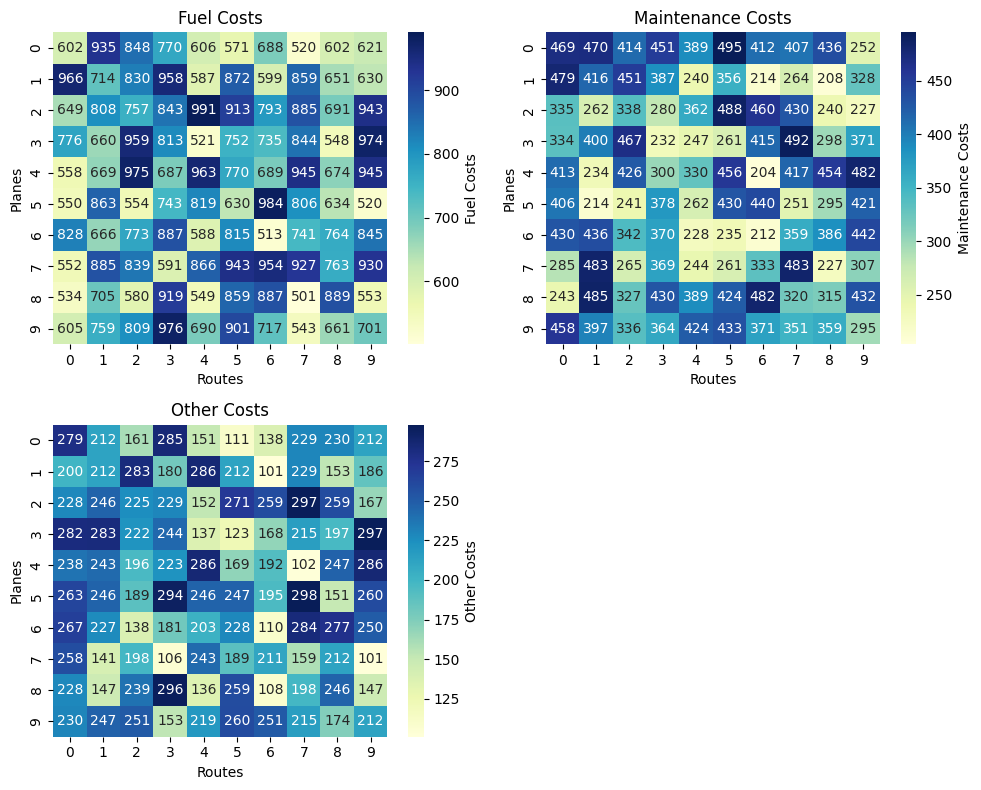

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyomo.environ import *
from pyomo.opt import SolverFactory

# Define the number of aircraft and routes
num_planes = 10
num_routes = 10

# Generate a synthetic cost matrix for each aircraft and route
np.random.seed(42)  # For reproducibility
fuel_costs = np.random.randint(500, 1000, size=(num_planes, num_routes))
maintenance_costs = np.random.randint(200, 500, size=(num_planes, num_routes))
other_costs = np.random.randint(100, 300, size=(num_planes, num_routes))

# Create heatmaps
plt.figure(figsize=(10, 8))  # Adjust the size to fit the 2x2 layout

# Heatmap for fuel costs
plt.subplot(2, 2, 1)
sns.heatmap(fuel_costs, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Fuel Costs'})
plt.title('Fuel Costs')
plt.xlabel('Routes')
plt.ylabel('Planes')

# Heatmap for maintenance costs
plt.subplot(2, 2, 2)
sns.heatmap(maintenance_costs, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Maintenance Costs'})
plt.title('Maintenance Costs')
plt.xlabel('Routes')
plt.ylabel('Planes')

# Heatmap for other costs
plt.subplot(2, 2, 3)
sns.heatmap(other_costs, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Other Costs'})
plt.title('Other Costs')
plt.xlabel('Routes')
plt.ylabel('Planes')

# Empty subplot
plt.subplot(2, 2, 4)
plt.axis('off')  # Hide axes for the empty subplot

plt.tight_layout()
plt.show()


In [35]:
# Assume you want to change the cost for aircraft 0 on route 1

# fuel_costs[0, 9] = 721  # Change the fuel cost for aircraft 0, route 1
# maintenance_costs[0, 9] = 1252  # Change the maintenance cost
# other_costs[0, 9] = 312  # Change the other costs

# Display the updated cost matrices

# print("Updated Fuel Costs:\n", fuel_costs)
# print("\nUpdated Maintenance Costs:\n", maintenance_costs)
# print("\nUpdated Other Costs:\n", other_costs)

# Calculate the new total cost matrix

# total_costs = fuel_costs + maintenance_costs + other_costs
# print("\nUpdated Total Costs:\n", total_costs)


### 2.3 Create the total cost matric C

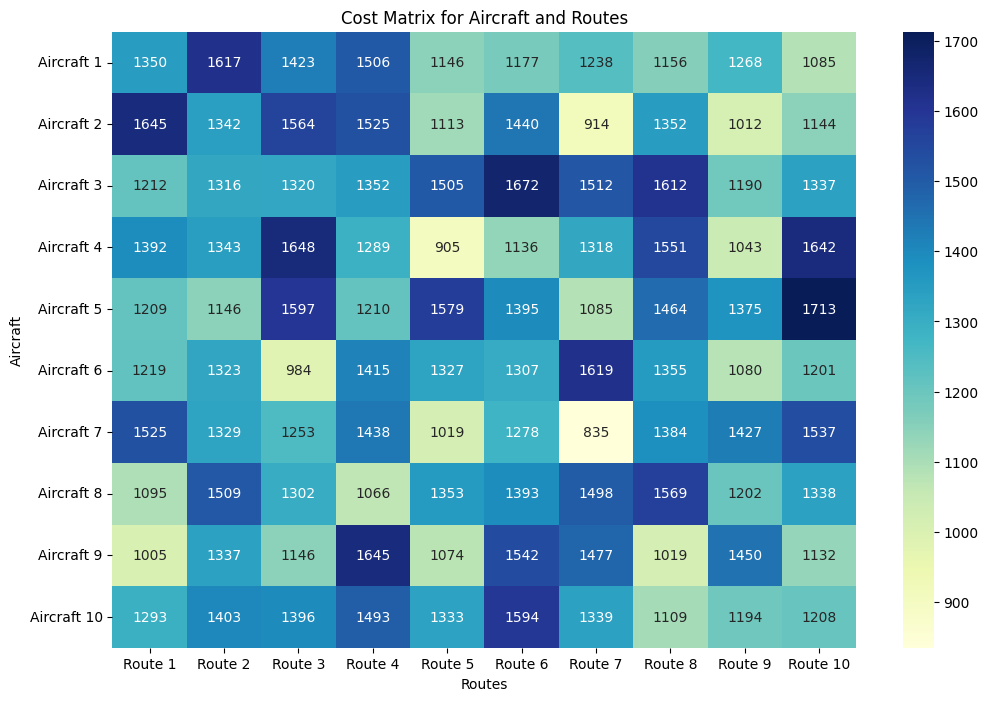

In [36]:
# Total cost matrix
total_costs = fuel_costs + maintenance_costs + other_costs

# Heatmap for the cost matrix
plt.figure(figsize=(12, 8))
sns.heatmap(total_costs, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=[f'Route {i+1}' for i in range(num_routes)],
            yticklabels=[f'Aircraft {i+1}' for i in range(num_planes)])
plt.title('Cost Matrix for Aircraft and Routes')
plt.xlabel('Routes')
plt.ylabel('Aircraft')
plt.show()


### 2.4 Implement the model in Pyomo and solve with GLPK

In [42]:
# Create a concrete model for assignment
model = ConcreteModel()

# Decision variables: x[i,j] = 1 if aircraft i is assigned to route j, otherwise 0
model.x = Var(range(num_planes), range(num_routes), within=Binary)

# Objective function: Minimize the total cost
def objective_rule(model):
    return sum(total_costs[i, j] * model.x[i, j] for i in range(num_planes) for j in range(num_routes))
model.objective = Objective(rule=objective_rule, sense=minimize)

# Each aircraft can be assigned to exactly one route
def one_assignment_rule(model, i):
    return sum(model.x[i, j] for j in range(num_routes)) == 1
model.one_assignment = Constraint(range(num_planes), rule=one_assignment_rule)

# Each route can be assigned to exactly one aircraft
def one_route_assignment_rule(model, j):
    return sum(model.x[i, j] for i in range(num_planes)) == 1
model.one_route_assignment = Constraint(range(num_routes), rule=one_route_assignment_rule)

# Solve the problem
solver = SolverFactory('glpk', executable='/usr/bin/glpsol')
solver.solve(model)

# Retrieve the assignments
assignments = np.zeros((num_planes, num_routes))
for i in range(num_planes):
    for j in range(num_routes):
        assignments[i, j] = model.x[i, j]()

# Calculate total costs per route
total_route_costs = np.zeros(num_routes)
for j in range(num_routes):
    for i in range(num_planes):
        total_route_costs[j] += total_costs[i, j] * assignments[i, j]

# Calculate component costs per route
fuel_cost_per_route = np.zeros(num_routes)
maintenance_cost_per_route = np.zeros(num_routes)
other_cost_per_route = np.zeros(num_routes)

for j in range(num_routes):
    for i in range(num_planes):
        fuel_cost_per_route[j] += fuel_costs[i, j] * assignments[i, j]
        maintenance_cost_per_route[j] += maintenance_costs[i, j] * assignments[i, j]
        other_cost_per_route[j] += other_costs[i, j] * assignments[i, j]


### 4. Results



#### 4.1 Optimal allocation of aircrafts to routes

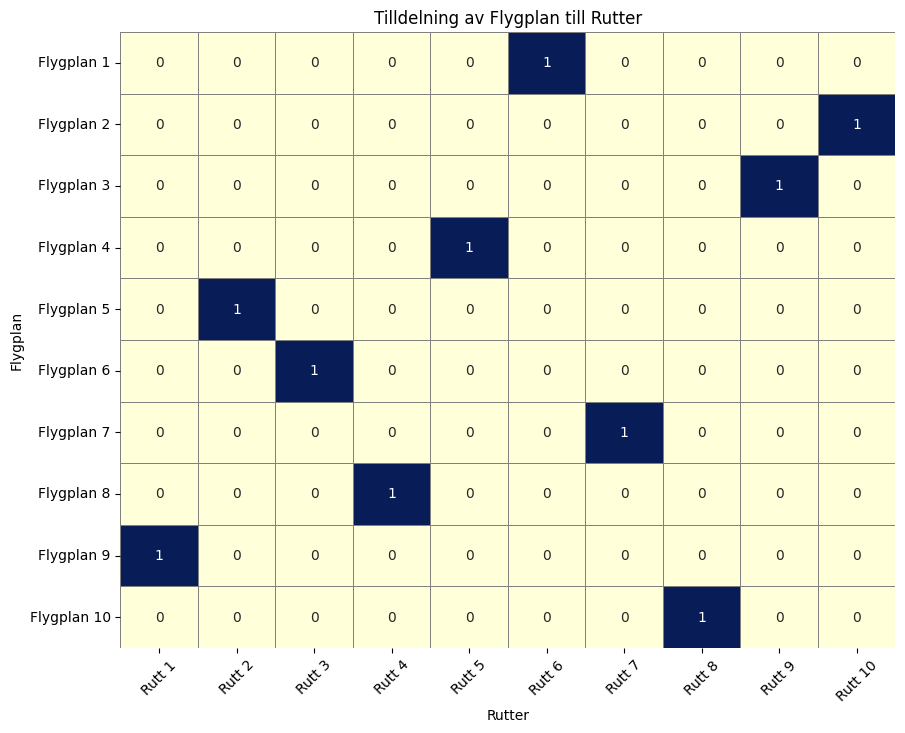

Total kostnad för allokeringen: 10561.00


In [43]:
# Visualisering av tilldelningen med heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(assignments, annot=True, cmap="YlGnBu", cbar=False, linewidths=0.5, linecolor='gray')
plt.xlabel('Rutter')
plt.ylabel('Flygplan')
plt.title('Tilldelning av Flygplan till Rutter')
plt.xticks(ticks=np.arange(num_routes) + 0.5, labels=[f"Rutt {j+1}" for j in range(num_routes)], rotation=45)
plt.yticks(ticks=np.arange(num_planes) + 0.5, labels=[f"Flygplan {i+1}" for i in range(num_planes)], rotation=0)
plt.show()

# Skriv ut den totala kostnaden
total_cost = model.objective()
print(f'Total kostnad för allokeringen: {total_cost:.2f}')

In [46]:
# Print the optimal solution
total_cost = model.objective()
print(f'Total cost: {total_cost:.2f}')

Total cost: 10561.00


#### 4.1 Kostnad per rutt

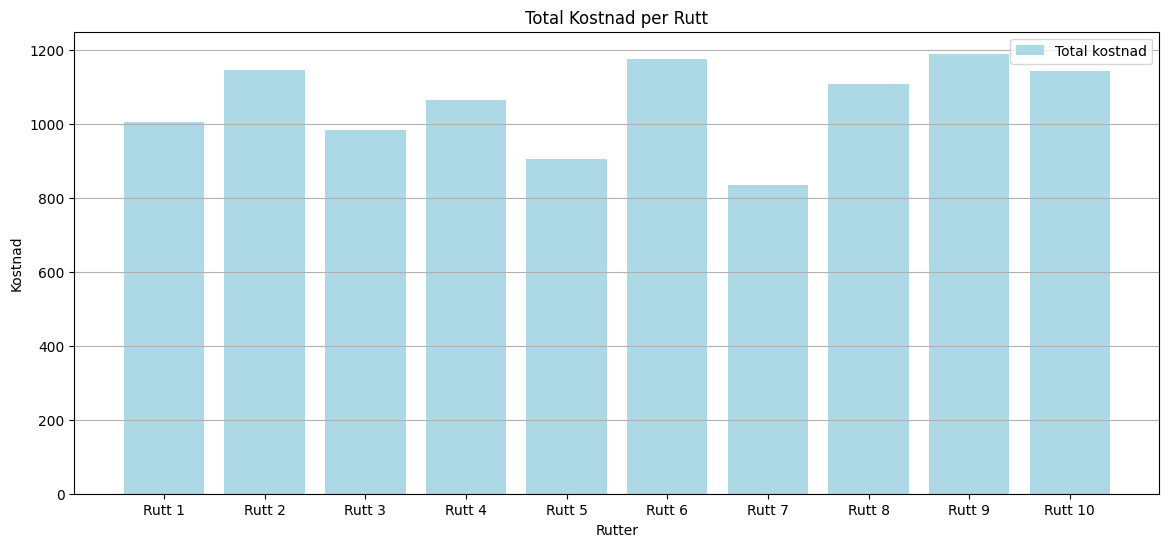

In [39]:
# Visualisering av totala kostnader per rutt
plt.figure(figsize=(14, 6))
plt.bar(range(num_routes), total_route_costs, color='lightblue', label='Total kostnad')
plt.xticks(range(num_routes), [f'Rutt {i+1}' for i in range(num_routes)])
plt.title('Total Kostnad per Rutt')
plt.xlabel('Rutter')
plt.ylabel('Kostnad')
plt.legend()
plt.grid(axis='y')
plt.show()

#### 4.2 Delkostnad per rutt

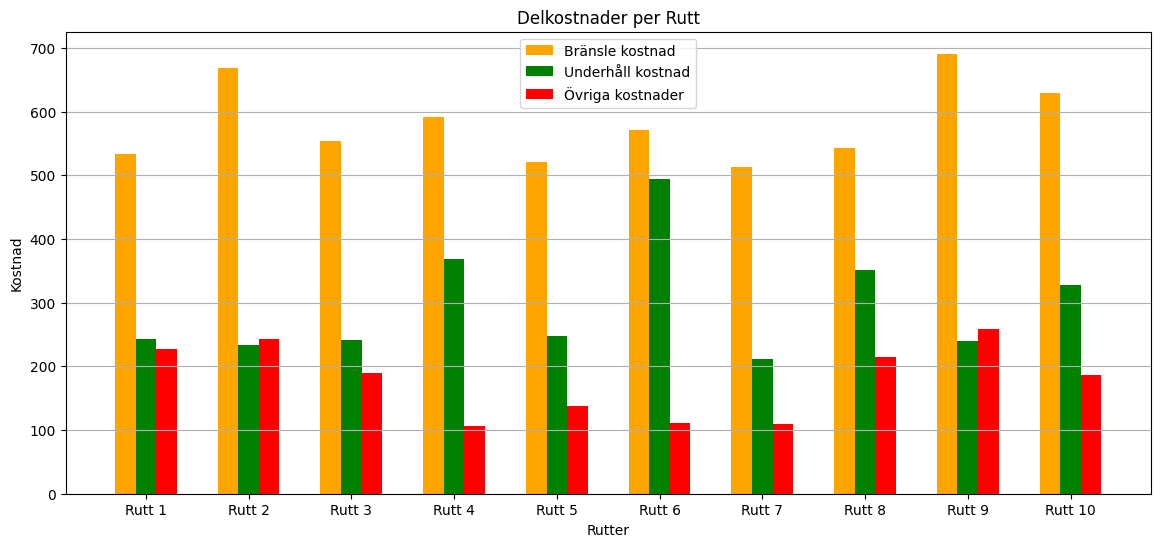

In [40]:
# Visualisering av delkostnader per rutt
bar_width = 0.2
x = np.arange(num_routes)

plt.figure(figsize=(14, 6))
plt.bar(x - bar_width, fuel_cost_per_route, width=bar_width, label='Bränsle kostnad', color='orange')
plt.bar(x, maintenance_cost_per_route, width=bar_width, label='Underhåll kostnad', color='green')
plt.bar(x + bar_width, other_cost_per_route, width=bar_width, label='Övriga kostnader', color='red')

plt.xticks(x, [f'Rutt {i+1}' for i in range(num_routes)])
plt.title('Delkostnader per Rutt')
plt.xlabel('Rutter')
plt.ylabel('Kostnad')
plt.legend()
plt.grid(axis='y')
plt.show()

### 5. Jämförelse med slumpmässig allokering

Optimerad kostnad: 10561.00
Slumpmässig kostnad: 12748.00
Förbättring: 2187.00


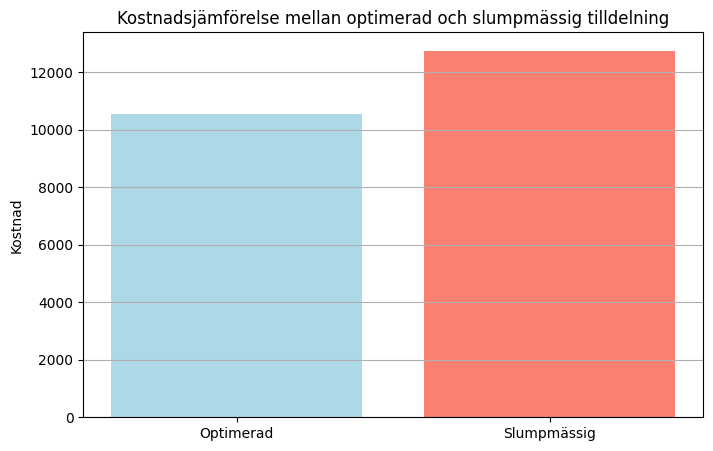

In [41]:
# Definiera antalet flygplan och rutter
num_planes = 10
num_routes = 10

# Syntetisk kostnadsmatris för varje flygplan och rutt
np.random.seed(42)  # För reproducerbarhet
fuel_costs = np.random.randint(500, 1000, size=(num_planes, num_routes))
maintenance_costs = np.random.randint(200, 500, size=(num_planes, num_routes))
other_costs = np.random.randint(100, 300, size=(num_planes, num_routes))

# Total kostnadsmatris
total_costs = fuel_costs + maintenance_costs + other_costs

# Skapa en konkret modell för tilldelning
model = ConcreteModel()

# Beslutsvariabler: x[i,j] = 1 om flygplan i tilldelas rutt j, annars 0
model.x = Var(range(num_planes), range(num_routes), within=Binary)

# Objektivfunktion: Minimera den totala kostnaden
def objective_rule(model):
    return sum(total_costs[i, j] * model.x[i, j] for i in range(num_planes) for j in range(num_routes))
model.objective = Objective(rule=objective_rule, sense=minimize)

# Varje flygplan kan tilldelas exakt en rutt
def one_assignment_rule(model, i):
    return sum(model.x[i, j] for j in range(num_routes)) == 1
model.one_assignment = Constraint(range(num_planes), rule=one_assignment_rule)

# Varje rutt kan tilldelas exakt ett flygplan
def one_route_assignment_rule(model, j):
    return sum(model.x[i, j] for i in range(num_planes)) == 1
model.one_route_assignment = Constraint(range(num_routes), rule=one_route_assignment_rule)

# Lös problemet
solver = SolverFactory('glpk', executable='/usr/bin/glpsol')
solver.solve(model)

# Hämta tilldelningarna
assignments = np.zeros((num_planes, num_routes))
for i in range(num_planes):
    for j in range(num_routes):
        assignments[i, j] = model.x[i, j]()

# Beräkna kostnaden för den optimerade tilldelningen
optimized_cost = model.objective()

# Slumptilldelning
def random_assignment(num_planes, num_routes):
    assignments_random = np.zeros((num_planes, num_routes))
    for j in range(num_routes):
        i = np.random.choice(range(num_planes))
        assignments_random[i, j] = 1
    return assignments_random

# Generera slumpmässig tilldelning
random_assignments = random_assignment(num_planes, num_routes)

# Beräkna kostnaden för den slumpmässiga tilldelningen
random_cost = sum(total_costs[i, j] * random_assignments[i, j] for i in range(num_planes) for j in range(num_routes))

# Jämför kostnader
print(f'Optimerad kostnad: {optimized_cost:.2f}')
print(f'Slumpmässig kostnad: {random_cost:.2f}')
print(f'Förbättring: {random_cost - optimized_cost:.2f}')

# Visualisera resultaten
labels = ['Optimerad', 'Slumpmässig']
costs = [optimized_cost, random_cost]

plt.figure(figsize=(8, 5))
plt.bar(labels, costs, color=['lightblue', 'salmon'])
plt.ylabel('Kostnad')
plt.title('Kostnadsjämförelse mellan optimerad och slumpmässig tilldelning')
plt.grid(axis='y')
plt.show()
